In [1]:
import ast
import json
import os
import shutil

import albumentations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom as dicom
import tensorflow as tf
import tensorflow_addons as tfa
import torch
from IPython.core.interactiveshell import InteractiveShell
from numba import cuda
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
from tqdm import tqdm

from src.generator import Generator, GetModel

InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv("/app/_data/train.csv")
list_wrong = df[(df["class"] != "negative") & (df["label"] == "none 1 0 0 1 1")][
    "id_image"
].tolist()
df = df.query("id_image not in @list_wrong").reset_index(drop=True)

with open("/app/_data/base_config.json", "r") as f:
    base_config = json.load(f)
base_config["EFFB7"]["SEED"] = 42
base_config

{'EFFB7': {'IMG_SIZE': 600,
  'BATCH_SIZE': 4,
  'SEED': 42,
  'WEIGHTS': '/app/_data/noisy-student-efficientnet-b7/efficientnetb7_notop.h5'},
 'CLASS': {'negative': 0, 'typical': 1, 'indeterminate': 2, 'atypical': 3},
 'EFFB4': {'IMG_SIZE': 380,
  'BATCH_SIZE': 50,
  'SEED': 42,
  'WEIGHTS': '/app/_data/efficientnet-b4_noisy-student_notop.h5'}}

In [3]:
df[['Negative for Pneumonia', 'Typical Appearance',
       'Indeterminate Appearance', 'Atypical Appearance', 'class']]

,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,class
0,0,1,0,0,typical
1,1,0,0,0,negative
2,0,1,0,0,typical
3,0,0,0,1,atypical
4,0,1,0,0,typical
...,...,...,...,...,...
6025,1,0,0,0,negative
6026,1,0,0,0,negative
6027,0,1,0,0,typical
6028,0,1,0,0,typical


In [4]:
weight_for_negative = (1 / sum(df["class"] == "negative")) * (df.shape[0] / 4.0)
weight_for_typical = (1 / sum(df["class"] == "typical")) * (df.shape[0] / 4.0)
weight_for_indeterminate = (1 / sum(df["class"] == "indeterminate")) * (
    df.shape[0] / 4.0
)
weight_for_atypical = (1 / sum(df["class"] == "atypical")) * (df.shape[0] / 4.0)
non_negative = (1 / sum(df["class"] != "negative")) * (df.shape[0] / 2.0)
negative = (1 / sum(df["class"] == "negative")) * (df.shape[0] / 2.0)
class_weights = {
    "output1": [
        weight_for_negative,
        weight_for_typical,
        weight_for_indeterminate,
        weight_for_atypical,
    ],
    "output2": [negative, non_negative],
}
class_weights


{'output1': [0.8683755760368663,
  0.5282060266292922,
  1.4370829361296473,
  3.855498721227622],
 'output2': [1.7367511520737327, 0.7021425244527247]}

# train

In [5]:
skf = StratifiedKFold(
    n_splits=5, random_state=base_config["EFFB7"]["SEED"], shuffle=True
)
train_ids = []
val_ids = []
for train_index, valid_index in skf.split(df, df["class"]):
    train_ids.append(train_index)
    val_ids.append(valid_index)

In [6]:
policy = keras.mixed_precision.experimental.Policy("mixed_float16")
keras.mixed_precision.experimental.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


0

255

(600, 600, 3)

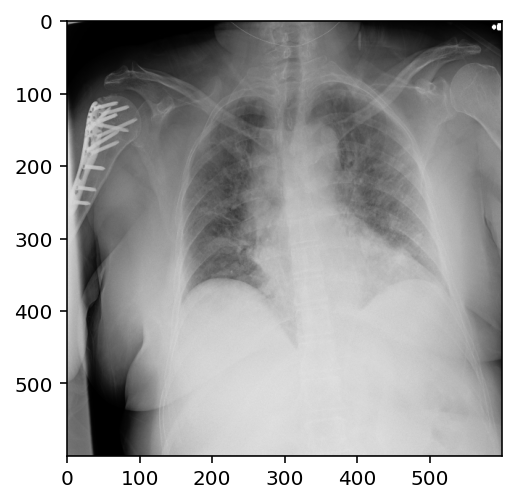

In [7]:
a = np.load("/app/_data/train_npy_600/" + os.listdir("/app/_data/train_npy_600/")[44])
a.min()
a.max()
plt.imshow(a)
a.shape

In [ ]:
for n in range(5):
    print("\n epoch #" + str(n) + "\n")
    val = df.loc[val_ids[n]].sample(frac=1, random_state=base_config["EFFB7"]["SEED"])
    train = df.loc[train_ids[n]].sample(
        frac=1, random_state=base_config["EFFB7"]["SEED"]
    )

    gen_train = Generator(
        df=train,
        batch_size=base_config["EFFB7"]["BATCH_SIZE"],
        seed=base_config["EFFB7"]["SEED"],
        img_size=base_config["EFFB7"]["IMG_SIZE"],
        prepared_img_path="/app/_data/train_npy_600/",
        shuffle=True,
        augment=False,
        hard_augment=False,
        trans_aug=False,
        flip_aug=False,
        n_inputs=1,
        n_classes=4,
        jpg=False,
        png=False,
        from_dicom=True,
    )
    gen_valid = Generator(
        df=val,
        batch_size=base_config["EFFB7"]["BATCH_SIZE"],
        seed=base_config["EFFB7"]["SEED"],
        img_size=base_config["EFFB7"]["IMG_SIZE"],
        prepared_img_path="/app/_data/train_npy_600/",
        shuffle=False,
        augment=False,
        hard_augment=False,
        flip_aug=False,
        n_inputs=1,
        n_classes=4,
        jpg=False,
        png=False,
        from_dicom=True,
    )

    get_m = GetModel(
        model_name="EFFB7",
        n_inputs=1,
        lr=0.0007,
        activation_func="softmax",
#         weights=base_config["EFFB7"]["WEIGHTS"],
        weights = 'imagenet',
        n_classes=4,
        top_dropout_rate=None,
    )
    model = get_m.get_model()

    callbacks = get_m.make_callback(
        model_path="/app/_data/models/EffB7_1in_fromdicom_noAug/",
        model_name="EffB7_0" + str(n) + ".h5",
        tensorboard_path="/app/.tensorboard/EffB7_1in_fromdicom_noAug" + str(n),
        patience_ES=20,
        patience_RLR=2,
        factor_LR=0.8,
        metric_for_monitor="val_acc",
        metric_mode="max",
    )

    history = model.fit(
        gen_train,
        validation_data=gen_valid,
        epochs=50,
        steps_per_epoch=len(train) // base_config["EFFB7"]["BATCH_SIZE"],
        validation_steps=len(val) // base_config["EFFB7"]["BATCH_SIZE"],
        verbose=1,
        workers=20,
        max_queue_size=500,
        callbacks=callbacks,
    )
    keras.backend.clear_session()


 epoch #0

  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)

Warning! Model path already exists.
Epoch 1/50


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/functional.py:592: UserWarning: Input dict contained keys ['data'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


1206/1206 [==============================] - 454s 312ms/step - loss: 1.8735 - acc: 0.3974 - auc: 0.5278 - val_loss: 54.0179 - val_acc: 0.4186 - val_auc: 0.4946

Epoch 00001: val_acc improved from -inf to 0.41860, saving model to /app/_data/models/EffB7_1in_fromdicom_noAug/EffB7_00.h5
Epoch 2/50
1206/1206 [==============================] - 303s 251ms/step - loss: 1.5030 - acc: 0.3945 - auc: 0.5037 - val_loss: 2.0555 - val_acc: 0.2807 - val_auc: 0.5179

Epoch 00002: val_acc did not improve from 0.41860
Epoch 3/50
1007/1206 [========================>.....] - ETA: 48s - loss: 1.5506 - acc: 0.3710 - auc: 0.4956

# evaluating

In [4]:
gen = Generator(
    df=df,
    batch_size=base_config["EFFB7"]["BATCH_SIZE"],
    seed=base_config["EFFB7"]["SEED"],
    img_size=base_config["EFFB7"]["IMG_SIZE"],
    prepared_img_path="/app/_data/train_jpg_600/",
    shuffle=False,
    augment=False,
    hard_augment=False,
    n_inputs=2,
    n_classes=4,
)

In [6]:
mod_path = "/app/_data/models/EffB7_init/"
for file in os.listdir(mod_path):
    if ".h5" in file:
        print(file)

EffB7_3.h5
EffB7_0.h5
EffB7_1.h5
EffB7_2.h5


In [5]:
mod_path = "/app/_data/models/EffB7_init/"
for file in os.listdir(mod_path):
    if ".h5" in file:
        model = keras.models.load_model(mod_path + file)
        model.evaluate(gen)
        keras.backend.clear_session()

1507/1507 [==============================] - 499s 328ms/step - loss: 0.2422 - acc: 0.7971 - recall: 0.7404 - precision: 0.8551 - f1_score: 0.7619


In [5]:
mod_path = "/app/_data/models/EffB7_2/"
for file in os.listdir(mod_path):
    if ".h5" in file:
        print(file)
        model = keras.models.load_model(mod_path + file)
        model.evaluate(gen)
        keras.backend.clear_session()

EffB7_3.h5
1507/1507 [==============================] - 320s 206ms/step - loss: 0.4167 - acc: 0.6744 - recall: 0.6176 - precision: 0.7273 - f1_score: 0.5826
EffB7_0.h5
1507/1507 [==============================] - 497s 326ms/step - loss: 0.3747 - acc: 0.6775 - recall: 0.5979 - precision: 0.7653 - f1_score: 0.5872
EffB7_1.h5
1507/1507 [==============================] - 514s 338ms/step - loss: 0.3693 - acc: 0.6792 - recall: 0.5906 - precision: 0.7759 - f1_score: 0.5906
EffB7_2.h5
1507/1507 [==============================] - 501s 329ms/step - loss: 0.3743 - acc: 0.6724 - recall: 0.5907 - precision: 0.7444 - f1_score: 0.5885
EffB7_4.h5
1507/1507 [==============================] - 532s 350ms/step - loss: 0.3499 - acc: 0.6966 - recall: 0.6339 - precision: 0.7642 - f1_score: 0.6068


In [7]:
mod_path = "/app/_data/models/EffB7_comp_data_0_softmax/"
for file in os.listdir(mod_path):
    if ".h5" in file:
        print(file)
        model = keras.models.load_model(mod_path + file)
        model.evaluate(gen)
        keras.backend.clear_session()

EffB7_c_1.h5
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6
1507/1507 [==============================] - 241s 155ms/step - loss: 0.2588 - acc: 0.7928 - recall: 0.7636 - precision: 0.8212 - f1_score: 0.7631
EffB7_c_2.h5
1507/1507 [==============================] - 248s 161ms/step - loss: 0.3700 - acc: 0.6749 - recall: 0.6257 - precision: 0.7250 - f1_score: 0.5922
EffB7_c_3.h5
1507/1507 [==============================] - 248s 160ms/step - loss: 0.3233 - acc: 0.7162 - recall: 0.6478 - precision: 0.8035 - f1_score: 0.6639
EffB7_c_4.h5
1507/1507 [==============================] - 226s 146ms/step - loss: 0.4215 - acc: 0.6291 - recall: 0.5717 - precision: 0.6708 - f1_score: 0.5457
EffB7_c_0_067.h5
1507/1507 [==============================] - 207s 134ms/step - loss: 0.3849 - acc: 0.6632 - recall_1: 0.62

In [8]:
mod_path = "/app/_data/models/EffB7_3/"
for file in os.listdir(mod_path):
    if ".h5" in file:
        print(file)
        model = keras.models.load_model(mod_path + file)
        model.evaluate(gen)
        keras.backend.clear_session()

EffB7_3.h5
1507/1507 [==============================] - 375s 246ms/step - loss: 0.3712 - acc: 0.6667 - recall: 0.5738 - precision: 0.7562 - f1_score: 0.5888
EffB7_0.h5
1507/1507 [==============================] - 529s 348ms/step - loss: 0.3892 - acc: 0.6666 - recall: 0.5941 - precision: 0.7284 - f1_score: 0.5757
EffB7_1.h5
1507/1507 [==============================] - 528s 347ms/step - loss: 0.4477 - acc: 0.6410 - recall: 0.6012 - precision: 0.6746 - f1_score: 0.5579
EffB7_2.h5
 865/1507 [================>.............] - ETA: 3:41 - loss: 0.3862 - acc: 0.6731 - recall: 0.5841 - precision: 0.7624 - f1_score: 0.5869

KeyboardInterrupt: 

## evaluation 2 class

In [9]:
gen2 = Generator(
    df=df,
    batch_size=base_config["EFFB7"]["BATCH_SIZE"],
    seed=base_config["EFFB7"]["SEED"],
    img_size=base_config["EFFB7"]["IMG_SIZE"],
    prepared_img_path="/app/_data/train_jpg_600/",
    shuffle=False,
    augment=False,
    hard_augment=False,
    n_inputs=2,
    n_classes=2,
)

In [10]:
mod_path = "/app/_data/models/EffB7_2class_1/"
for file in os.listdir(mod_path):
    if ".h5" in file:
        print(file)
        model = keras.models.load_model(mod_path + file)
        model.evaluate(gen2)
        keras.backend.clear_session()

EffB7_2cl_2.h5
1507/1507 [==============================] - 223s 145ms/step - loss: 0.3971 - acc: 0.8230 - recall: 0.8230 - precision: 0.8231 - f1_score: 0.8252
EffB7_2cl_1.h5
1507/1507 [==============================] - 213s 138ms/step - loss: 0.2898 - acc: 0.8769 - recall: 0.8769 - precision: 0.8769 - f1_score: 0.8733
EffB7_2cl_0.h5
1507/1507 [==============================] - 518s 341ms/step - loss: 0.4272 - acc: 0.8056 - recall: 0.8056 - precision: 0.8056 - f1_score: 0.8027
EffB7_2cl_4.h5
1507/1507 [==============================] - 215s 140ms/step - loss: 0.3666 - acc: 0.8442 - recall: 0.8442 - precision: 0.8442 - f1_score: 0.8400
EffB7_2cl_3.h5
1507/1507 [==============================] - 227s 147ms/step - loss: 0.3073 - acc: 0.8668 - recall: 0.8668 - precision: 0.8668 - f1_score: 0.8628
